<a href="https://colab.research.google.com/github/MedicalImageAnalysisTutorials/DeepLearning4All/blob/main/IA_DNN_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook, I will try to provide a practical tutorial for deep learning using simple examples. I will try to use simple implementation and avoid using built-in functions to give clear idea about the concept. You need basic programming knowledge. 

**The Classification Problem:**

We have data represented usually by an array (could be 1D, 2D, or ND). Note the images usually are 3D arrays e.g. with size hight,width,channels.

We also have "labels" or "classes" so for each sample in our data we have its class or label. 

An example:

                 index     sample (X)     label (Y)  
                  1         image1          car                      
                  2         image2          car                      
                  3         image3          dog                               
                  4         image4          bike                      
                  5         image5          bike                             
                  6         image6          dog                      
                  .
                  .
                  . 


Another example:

                 index         sample (X)         label (Y)  
                  1         [20 24 25 ... 23]        1                      
                  2         [10 20 8  ... 50]        2
                  3         [40 24 12 ... 11]        1                      
                  4         [12 15 30 ... 60]        1
                  5         [19 70 25 ... 22]        1                      
                  6         [0  90 23 ... 10]        2
                  .
                  .
                  . 


We want to find a way to predict the class or the label for new samples that we do not know. 

There are many machine learning algorithms available e.g. [K-nearest_neighbors  (KNN)](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) algorithm or [support vector machine (SVM)](https://en.wikipedia.org/wiki/Support-vector_machine)

Here we will investigate the [neural network (NN)](http://neuralnetworksanddeeplearning.com/chap1.html) and the [convolution neural networks (CNN)](https://www.analyticsvidhya.com/blog/2018/12/guide-convolutional-neural-network-cnn/) approaches. 

I made the code flexible so one can try different approaches, datsaets, optimisers, loss functions based on if else statements. 

The general code structure:

    1. Read and pre-process the data
    2. Create the model, optimiser, loss function, and metrics
    3. Start the training loop
    4. Evaluate the final model




In [17]:
# Setup 
import os, random, time
import numpy as np
import matplotlib.pyplot as plt
import cv2 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import datasets, layers, models

# Image classification using NN

I will use two popular public datasets [MINST](http://yann.lecun.com/exdb/mnist/) and [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). Both have 10 classes. 

## Reading and exploring the datasets



dataset shape   :  (50000, 28, 28, 1)
number of images:  50000
image size      :  (28, 28, 1)
image data type :  <class 'numpy.uint8'>
image max  value:  255
image min  value:  0
gray or binary image (not color image)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


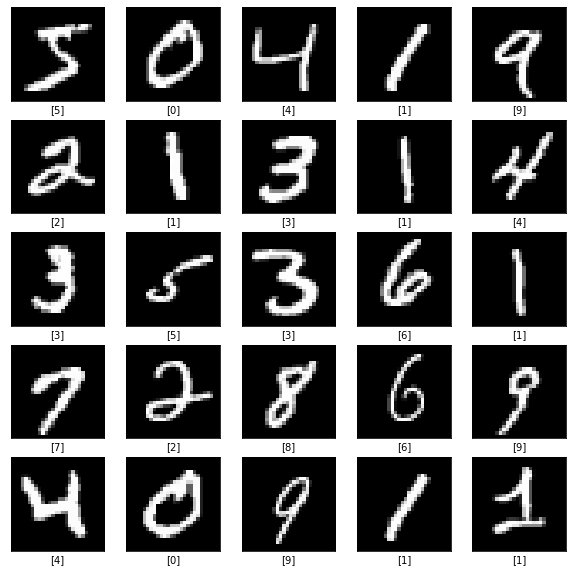

In [18]:
datasetID = 1  # minst is selected by default, for cifar10 use 2
NNID      = 1  # NN is by default, for DNN use 2 
number_of_classes = 10  # each datasets have 10 classes


# minst dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
class_names = range(10)
if datasetID==2:
    # cifar10 dataset
    # The CIFAR10 dataset contains 60,000 color images in 10 classes, 
    # with 6,000 images in each class.
    # The dataset is divided into 50,000 training images and 10,000 testing images.
    # The classes are mutually exclusive and there is no overlap between them.

    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# get size 
h = x_train.shape[1] # image height
w = x_train.shape[2] # image width
# check for rgb 
try:
    # number of channels
    c =  x_train.shape[3]
except:
    # number of channels
    c =  1
    # if there is no number of channels, add 1
    x_train  =  x_train[..., np.newaxis] # np.reshape(x_train, (-1, h,w,1))
    y_train  =  y_train[..., np.newaxis] # np.reshape(y_train, (-1, h,w,1))
    x_test   =  x_test[..., np.newaxis]  # np.reshape(x_test,  (-1, h,w,1))
    y_test   =  y_test[..., np.newaxis]  # np.reshape(y_test,  (-1, h,w,1))


# Reserve 10,000 samples for validation.
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

number_of_pixels = h * w * c

# if you have large GPU memory you can combine the images to batches 
# for faster training.
# It is good to try different values
batch_size = 64 # you can try larger batch size e.g. 1024 * 6

print("dataset shape   : ",x_train.shape)
print("number of images: ",x_train.shape[0])
print("image size      : ",x_train[0].shape)
print("image data type : ",type(x_train[0][0][0][0]))
print("image max  value: ",np.max(x_train[0]))
print("image min  value: ",np.min(x_train[0]))
if c==1:
   print("gray or binary image (not color image)")
elif c==3:
   print("rgb color image (or probably non-color image represented with 3 channels)")




# display sample images 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #plt.imshow(x_train[i])
    plt.imshow(cv2.cvtColor(x_train[i], cv2.COLOR_BGR2RGB))

    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    if datasetID==1:
       plt.xlabel(y_train[i])
    elif datasetID==2:
       plt.xlabel(class_names[y_train[i][0]])
plt.show()


# normalisation
x_train = np.array([ x/255.0 for x in x_train])
x_val   = np.array([ x/255.0 for x in x_val])
x_test  = np.array([ x/255.0 for x in x_test])
#y_train = y_train.astype(np.float32)

# for NN we need 1D 
if NNID ==1:
   x_train = np.reshape(x_train, (-1, number_of_pixels))
   x_val   = np.reshape(x_val,  (-1, number_of_pixels))
   x_test  = np.reshape(x_test , (-1, number_of_pixels))



# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
#train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

# Prepare the test dataset.
tst_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
tst_dataset = tst_dataset.batch(batch_size)



## Creating NN model



In [19]:
# NN TensorFlow
def getNNModel(number_of_pixels,number_of_classes):
    inputs = keras.Input(shape=(number_of_pixels,), name="digits")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(64, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(number_of_classes, name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model
print("NN model is defined ...")

NN model is defined ...


In [20]:
# TODO
# NN pytorch


## Define optimiser and loss function

In [21]:
# Instantiate an optimizer to train the model.

optimiserID = 1 # SGD by default for ADAM use 2 
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
if optimiserID ==2:
   optimizer = keras.optimizers.Adam()#learning_rate=0.0001
# Instantiate a loss function.

lossFunctionID = 2 # SparseCategoricalCrossentropy by default for MSE use 2 
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric   = keras.metrics.SparseCategoricalAccuracy()
tst_acc_metric   = keras.metrics.SparseCategoricalAccuracy()
if lossFunctionID==2:
   loss_fn = keras.losses.MeanSquaredError()
   # Prepare the metrics.
   train_acc_metric = keras.metrics.MeanSquaredError()
   val_acc_metric   = keras.metrics.MeanSquaredError()
   tst_acc_metric   = keras.metrics.MeanSquaredError()

elif  lossFunctionID==3:
   loss_fn = keras.losses.CategoricalCrossentropy()
   # Prepare the metrics.
   train_acc_metric = keras.metrics.CategoricalCrossentropy()
   val_acc_metric   = keras.metrics.CategoricalCrossentropy()
   tst_acc_metric   = keras.metrics.CategoricalCrossentropy()
print("optimiser, loss, and metrics are defined .... ")

optimiser, loss, and metrics are defined .... 


In [22]:
# TODO
# Pytorch


## Training our NN model


               Training Loop           
epoch:0 	 trnLoss: 4.0845 	 valLoss: 6.1385 	 trnAcc: 6.6428 	 valAcc: 4.2381 	 time:  2.51


<Figure size 432x288 with 0 Axes>

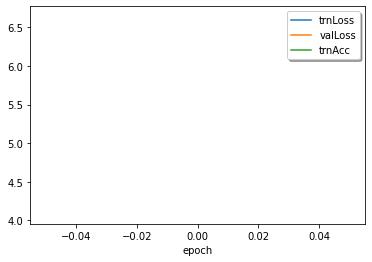

epoch:1 	 trnLoss: 3.9343 	 valLoss: 4.2979 	 trnAcc: 4.1455 	 valAcc: 3.6763 	 time:  1.77
epoch:2 	 trnLoss: 3.1760 	 valLoss: 3.1684 	 trnAcc: 3.6378 	 valAcc: 3.2605 	 time:  1.75
epoch:3 	 trnLoss: 4.0483 	 valLoss: 2.4301 	 trnAcc: 3.1923 	 valAcc: 2.8335 	 time:  1.74
epoch:4 	 trnLoss: 3.0228 	 valLoss: 1.9056 	 trnAcc: 2.7810 	 valAcc: 2.4704 	 time:  1.73
epoch:5 	 trnLoss: 1.6692 	 valLoss: 1.5449 	 trnAcc: 2.4438 	 valAcc: 2.1895 	 time:  1.72
epoch:6 	 trnLoss: 2.5793 	 valLoss: 1.3639 	 trnAcc: 2.1835 	 valAcc: 1.9775 	 time:  1.73
epoch:7 	 trnLoss: 1.3053 	 valLoss: 1.1314 	 trnAcc: 1.9824 	 valAcc: 1.8166 	 time:  1.78
epoch:8 	 trnLoss: 1.5943 	 valLoss: 1.0090 	 trnAcc: 1.8219 	 valAcc: 1.6898 	 time:  1.75
epoch:9 	 trnLoss: 0.8050 	 valLoss: 0.9046 	 trnAcc: 1.6886 	 valAcc: 1.5757 	 time:  1.76
epoch:10 	 trnLoss: 1.6436 	 valLoss: 0.8848 	 trnAcc: 1.5788 	 valAcc: 1.5610 	 time:  1.75
epoch:11 	 trnLoss: 1.5555 	 valLoss: 0.7897 	 trnAcc: 1.4886 	 valAcc: 1.4078 

<Figure size 432x288 with 0 Axes>

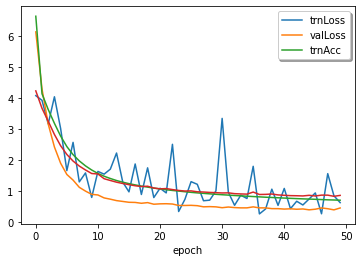

Training this dataset took  88.2134096622467  seconds!
Training this dataset took  1.4702234943707784  minutes!


In [23]:

# define training parameters and file paths 

epochs = 50 # number of iterations 

# model log files path
modelPath   = "./modelClassification.h5"
logFilePath = "./training_log.csv"
figPath     = "./training_log.png"

logFile = open(logFilePath,'w')
logFile.write("epoch \t trnLoss \t valLoss \t trnAcc \t valAcc \t time \n" )
logFile.close()
# Using optimised tensorflow functions provides more speed

@tf.function
def train_step(model,x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        #y = keras.utils.to_categorical(y)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def val_step(model,x, y):
    val_logits = model(x, training=False)
    #y = keras.utils.to_categorical(y)
    loss_value = loss_fn(y, val_logits)
    val_acc_metric.update_state(y, val_logits)
    return loss_value

# plotting function to monitor the curves
def iaPlotLoss(logPath,figPath=None):
    f = open(logPath,'r')
    lst = f.readlines()
    # first line is labels:
    labels = lst[0].split()[1:-2]
    x  = [ int(  ln.split()[0]) for ln in lst[1:]] # epoch
    y1 = [ float(ln.split()[1]) for ln in lst[1:]] # lossTrain
    y2 = [ float(ln.split()[2]) for ln in lst[1:]] # lossValidation
    y3 = [ float(ln.split()[3]) for ln in lst[1:]] # accTrain
    y4 = [ float(ln.split()[4]) for ln in lst[1:]] # accValidation
    #plotting    
    plt.clf()
    fig, ax = plt.subplots()    
    l1, = ax.plot(x, y1) ;     l2, = ax.plot(x, y2) ;
    l3, = ax.plot(x, y3) ;     l4, = ax.plot(x, y4) ;
    ax.legend((l1, l2,l3,l4), labels, loc='upper right', shadow=True)
    plt.xlabel('epoch')
    if figPath:
        plt.savefig(figPath, bbox_inches='tight')
    else:
        plt.show()
        plt.close()

if NNID==1:
    model = getNNModel(number_of_pixels,number_of_classes)
    print("===================================================")
    print("               Training Loop           ")
    print("===================================================")

    total_time_start = time.time()
    # we loop number of iterations
    # for each iteration, we loop through all the training samples
    for epoch in range(epochs):
        #print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()

        # Iterate over the batches of the dataset.
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            loss_value = train_step(model,x_batch_train, y_batch_train)

        train_acc = train_acc_metric.result()
        train_acc_metric.reset_states()

        # Run a validation loop at the end of each epoch.
        for x_batch_val, y_batch_val in val_dataset:
            val_loss_value = val_step(model,x_batch_val, y_batch_val)

        val_acc = val_acc_metric.result()
        val_acc_metric.reset_states()
        
        # compute time required for each epoch
        end_time = time.time() - start_time

        print("epoch:%d \t trnLoss: %.4f \t valLoss: %.4f \t trnAcc: %.4f \t valAcc: %.4f \t time:  %.2f" % (epoch, float(loss_value),float(val_loss_value), float(train_acc), float(val_acc), end_time))
        logFile = open(logFilePath,'a')
        logFile.write("%d \t %.4f \t  %.4f \t %.4f \t  %.4f \t  %.2f \n" % (epoch, float(loss_value),float(val_loss_value), float(train_acc), float(val_acc), end_time))
        logFile.close()
        # plot the result
        if epoch % 50 ==0:
           # plot the result        
           iaPlotLoss(logFilePath)

    # save the final model
    model.save(modelPath)     

    # plot the result        
    iaPlotLoss(logFilePath)
    total_time_end = time.time() - total_time_start
    print("Training this dataset took ", total_time_end," seconds!") 
    print("Training this dataset took ", total_time_end/60.0," minutes!")   

In [24]:
#TODO pytorch

## Evaluation

In [25]:
if NNID==1:
    # Load the saved model 
    model = keras.models.load_model(modelPath, compile=False)

    start_time = time.time() 
    # Run a validation loop at the end of each epoch.
    for x_batch_tst, y_batch_tst in tst_dataset:
        output = model.predict(x_batch_tst)
        #y = keras.utils.to_categorical(y_batch_tst)
        tst_acc_metric.update_state(y_batch_tst, output)

    tst_acc = tst_acc_metric.result()

    # compute time required for each epoch
    end_time = time.time() - start_time

    print("test accuracy : %.4f \t time:  %.2f" % (  float(tst_acc), end_time))

test accuracy : 0.8961 	 time:  7.09


In [26]:
# TODO Pytorch


# Image classification using CNN


## Creating our CNN model

In [27]:
# Simple DNN
# just two conolution layers followed by dense layer
def getSimpleDNNModel(input_shape,number_of_pixels,number_of_classes):
    nF        = 16 # number of filters
    inputs = keras.Input(shape=input_shape, name="images") 
    # Create CNN model
    x11  = layers.Conv2D(nF, (3, 3), activation='relu', input_shape=input_shape) (inputs)
    x13  = layers.MaxPooling2D((2, 2)) (x11)
    x21  = layers.Conv2D(2*nF, (3, 3), activation='relu') (x13)
    x23  = layers.MaxPooling2D((2, 2))(x21)
    #dense layer for classification
    x31 = layers.Flatten()(x23)# convert from 3d to 1d
    outputs = layers.Dense(number_of_classes, name="predictions")(x31)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# this is a better model for CIFAR10
def getDNNModel(input_shape,number_of_pixels,number_of_classes):
    nF        = 64 # number of filters
    inputs = keras.Input(shape=input_shape, name="images") 
    # Create CNN model
    x11  = layers.Conv2D(nF, (3, 3), activation='relu', input_shape=input_shape) (inputs)
    x12  = layers.BatchNormalization()(x11)
    x13  = layers.MaxPooling2D((2, 2)) (x12)
    x14  = layers.Dropout(0.25)(x13)
    x21  = layers.Conv2D(2*nF, (3, 3), activation='relu') (x14)
    x22  = layers.BatchNormalization()(x21)
    x23  = layers.MaxPooling2D((2, 2))(x22)
    x24  = layers.Dropout(0.25)(x23)
    x31  = layers.Conv2D(2*nF, (3, 3), activation='relu')(x24)
    #dense layer for classification
    x41 = layers.Flatten()(x31)# convert from 3d to 1d
    #x7 = layers.Dense(2*nF, activation='relu')(x6)
    #x8 = layers.Dense(2*nF, activation='relu')(x7)
    x42  = layers.Dropout(0.50)(x41)
    outputs = layers.Dense(number_of_classes, name="predictions")(x42)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model
print("DNN model is defined ...")    


DNN model is defined ...


## Training CNN model

In [28]:
# Same code as above 

epochs = 50 # number of iterations 

if NNID==2:
    input_shape = [h,w,c]
    model = getSimpleDNNModel(input_shape, number_of_pixels,number_of_classes)
    print("===================================================")
    print("               Training Loop           ")
    print("===================================================")
    total_time_start = time.time()
    # we loop number of iterations
    # for each iteration, we loop through all the training samples
    for epoch in range(epochs):
        #print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()

        # Iterate over the batches of the dataset.
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            loss_value = train_step(model,x_batch_train, y_batch_train)

        train_acc = train_acc_metric.result()
        train_acc_metric.reset_states()

        # Run a validation loop at the end of each epoch.
        for x_batch_val, y_batch_val in val_dataset:
            val_loss_value = val_step(model,x_batch_val, y_batch_val)

        val_acc = val_acc_metric.result()
        val_acc_metric.reset_states()
        
        # compute time required for each epoch
        end_time = time.time() - start_time

        print("epoch:%d \t trnLoss: %.4f \t valLoss: %.4f \t trnAcc: %.4f \t valAcc: %.4f \t time:  %.2f" % (epoch, float(loss_value),float(val_loss_value), float(train_acc), float(val_acc), end_time))
        logFile = open(logFilePath,'a')
        logFile.write("%d \t %.4f \t  %.4f \t %.4f \t  %.4f \t  %.2f \n" % (epoch, float(loss_value),float(val_loss_value), float(train_acc), float(val_acc), end_time))
        logFile.close()
        if epoch % 50 ==0:
           # plot the result        
           iaPlotLoss(logFilePath)

    # save the final model
    model.save(modelPath)     

    # plot the result        
    iaPlotLoss(logFilePath)
    total_time_end = time.time() - total_time_start
    print("Training this dataset took ", total_time_end," seconds!") 
    print("Training this dataset took ", total_time_end/60.0," minutes!") 


## Evaluation

In [29]:
if NNID==2:
    # Load the saved model 
    model = keras.models.load_model(modelPath, compile=False)

    start_time = time.time() 
    # Run a validation loop at the end of each epoch.
    for x_batch_tst, y_batch_tst in tst_dataset:
        output = model.predict(x_batch_tst)
        #y = keras.utils.to_categorical(y_batch_tst)
        tst_acc_metric.update_state(y_batch_tst, output)

    tst_acc = tst_acc_metric.result()

    # compute time required for each epoch
    end_time = time.time() - start_time

    print("test accuracy : %.4f \t time:  %.2f" % (  float(tst_acc), end_time))

# More resources:

* 3Blue1Brown Neural Network [video tutorials](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi) 
* Deep Learning Video Lectures by Prof. Andreas Maier [Winter 20/21](https://www.youtube.com/watch?v=SCFToE1vM2U&list=PLpOGQvPCDQzvJEPFUQ3mJz72GJ95jyZTh)
* Some of the code in this notebook is taken from [here](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)
* Calculating number of parameters in [CNN](https://towardsdatascience.com/understanding-and-calculating-the-number-of-parameters-in-convolution-neural-networks-cnns-fc88790d530d)
* Some of the code in this notebook is taken from [here](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb)
